In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 25.0MB 2.1MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 144kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle 

In [4]:
path_traindis='/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TrainingSet/Disguise/'
path_traingen='/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TrainingSet/Genuine/'
path_trainref='/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TrainingSet/Reference/'
path_trainsim='/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TrainingSet/Simulated/'
path_testque='/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TestSet/Questioned/'
path_testref='/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TestSet/Reference/'

In [9]:
def convert_to_pkl (dat,filename):
    dbfile=open(filename,'wb')
    pickle.dump(dat,dbfile)
    dbfile.close()
    dbfile=open(filename,'rb')
    return pickle.load(dbfile)

def Local_Stable_features(path,feat):

    # Perform SURF for each Reference Image

    images = os.listdir(path)
    images=sorted(images)
    print(images)
    Key_des = []
    Key_points= []
    if feat=='surf':
      surf = cv2.xfeatures2d.SURF_create(hessianThreshold = 1000, extended = 1)
    elif feat=='sift':
      surf = cv2.xfeatures2d.SIFT_create()
    elif feat=='ORB':
      surf = cv2.ORB_create(nfeatures=500)
    img=np.array([cv2.imread(path+me,0) for me in images if (me[len(me)-4:len(me)]==".png" or me[len(me)-4:len(me)]==".PNG" or me[len(me)-5:len(me)]==".jpeg")])
    n=img.shape[0]
    Key_points=np.array([surf.detectAndCompute(img[i], None)[0] for i in range(n)])
    Key_des=np.array([surf.detectAndCompute(img[i], None)[1] for i in range(n)])

    # Find stable keypoints
    Stable_des   = []
    st_pnt = []
    unst_pnt = []
    for i in range(Key_des.shape[0]):
        indexes = list(range(Key_des.shape[0]))                                # Generate LOO database
        indexes.pop(i)
        tmp_db = np.concatenate(Key_des[indexes])

        total_dist = 0                                                         # Find minimum distance for each keypoint
        distances = []
        for keypoint in Key_des[i]:
            min_dist = np.min(np.linalg.norm(tmp_db - keypoint, axis=1))       # distance from the respective keypoint from its matched point
            total_dist += min_dist
            distances.append(min_dist)
        avg_dist = total_dist / Key_des[i].shape[0]

        st_ind = np.where(distances <= avg_dist)[0]                               # Append keypoints less than average distance
        st_pnt.append([Key_points[i][j] for j in st_ind])

        unst_ind = np.where(distances > avg_dist)[0]
        unst_pnt.append([Key_points[i][j] for j in unst_ind])

        Stable_des.extend(list(Key_des[i][np.where(distances <= avg_dist)]))

    Stable_des = np.stack(Stable_des)
    plt.figure(figsize = (50, 50), dpi = 60)
    for i in range(img.shape[0]):
       
        
        tmp1 = cv2.drawKeypoints(img[i],unst_pnt[i],None,color = (255,0,0))
        tmp2 = cv2.drawKeypoints(img[i],st_pnt[i],None,color = (0,255,0))
        plt.subplot(img.shape[0],2,2*i+1)

        plt.imshow(tmp2)
        plt.axis('off')
        plt.title('Stable Keypoints')

        plt.subplot(img.shape[0],2,2*i+2)
        plt.imshow(tmp1)
        plt.axis('off')
        plt.title('Unstable Keypoints')

    plt.show()
    return Stable_des

In [5]:
def classify(img, DB, thresh,parameter):

  match_percent=0
  num_points_stable=0
  num_points_slightly_stable=0
  num_points_unstable=0
  kp_stable=[]
  kp_slightly_stable=[]
  kp_unstable=[]
  surf = cv2.xfeatures2d.SURF_create(hessianThreshold = 1000, extended = 1)
  surf_info = surf.detectAndCompute(img, None)
  keypoints=surf_info[0]
  k=0
  for point in surf_info[1]:
    min=np.min(np.linalg.norm(DB-point,axis=1))
    #print("printing min")
    #print(min)
    if min <= thresh:
      num_points_stable +=1
      kp_stable.append(keypoints[k])
    else:
      if min <= 3*thresh:
        num_points_slightly_stable +=1
        kp_slightly_stable.append(keypoints[k])
      else:
        num_points_unstable +=1  
        kp_unstable.append(keypoints[k])
    k=k+1    
  #print("done")    
  if parameter==1:
    return num_points_stable/surf_info[1].shape[0]
  else:
    return kp_stable,kp_slightly_stable,kp_unstable

['R001.png', 'R002.png', 'R003.png', 'R004.png', 'R005.png', 'R006.png', 'R007.PNG', 'R008.png', 'R009.png']


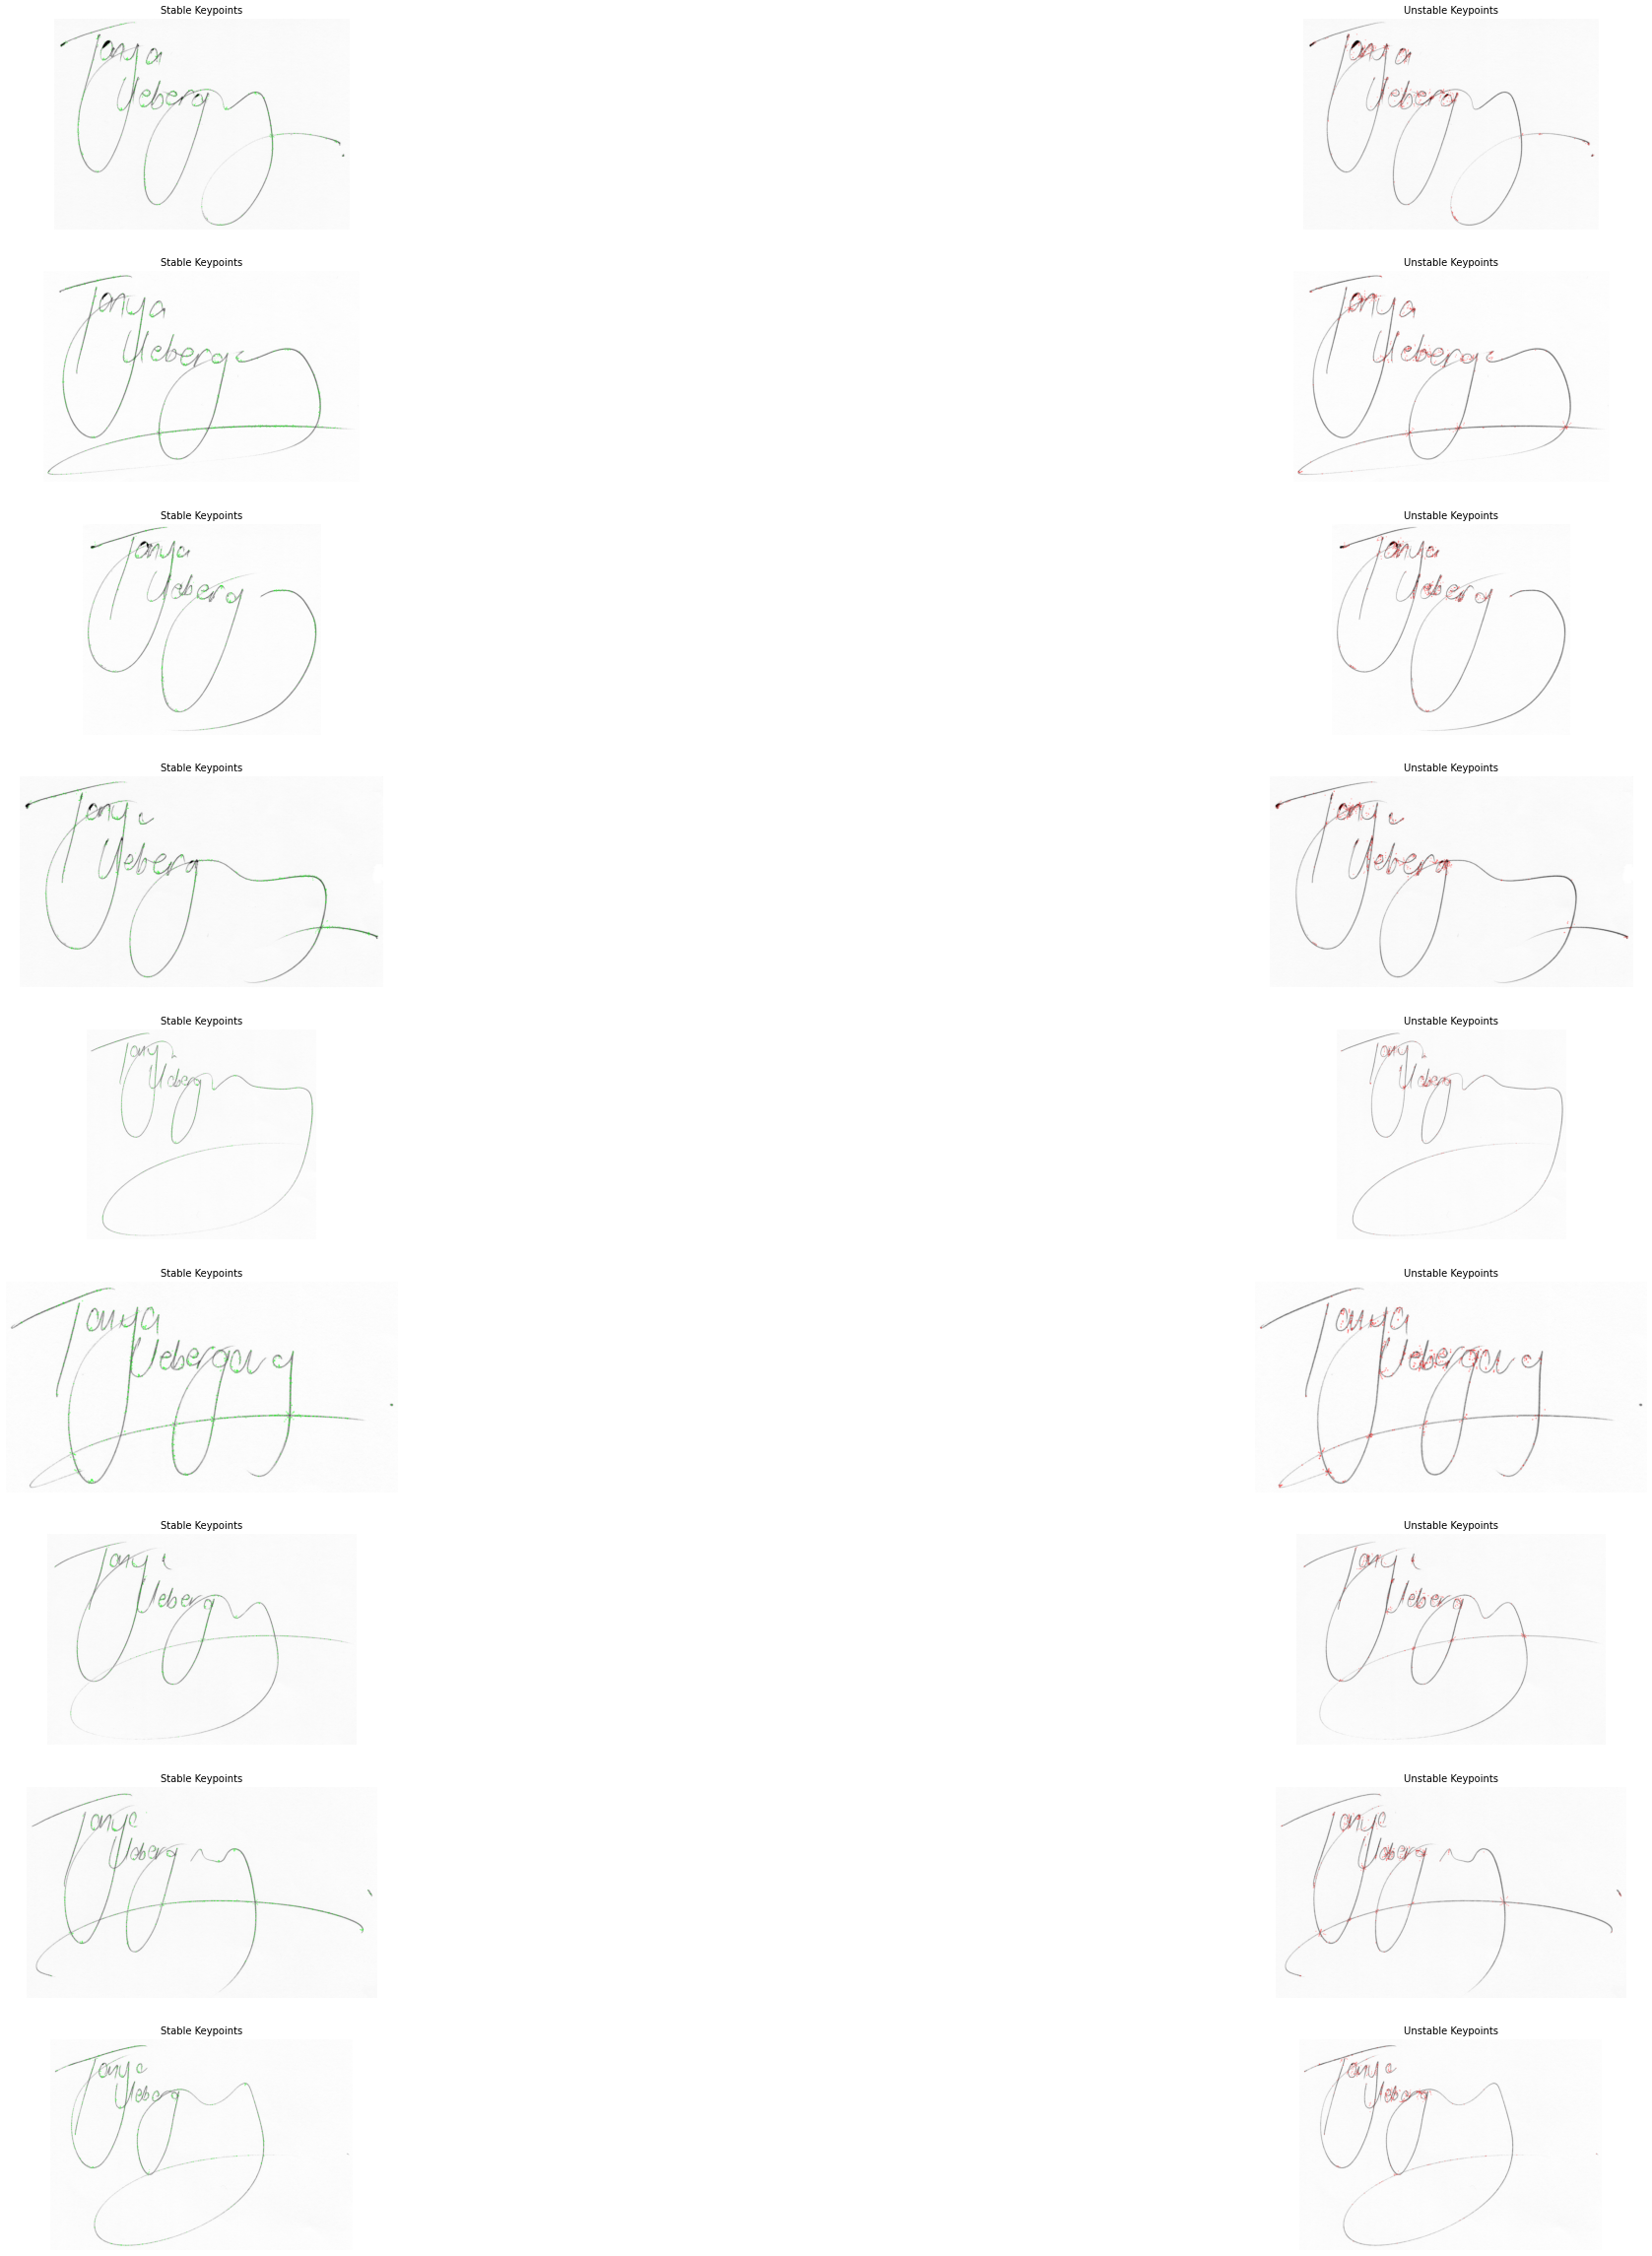

Genuine Signatures
Disguise Signatures
Simulated Signatures


In [11]:
import os
import cv2
import pickle
import threading
import numpy as np
import matplotlib.pyplot as plt
# User defined Modules





# Load/Save DB
DB = Local_Stable_features('/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TrainingSet/Reference/','surf')
DB = convert_to_pkl(DB,'/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Pickles/database.pkl')
threshold = 0.11


# Matched Points Percentage for each type of signature
print("Genuine Signatures")
img = []
genuine_match=[]
disguise_match=[]
simulated_match=[]
file_names = os.listdir(path_traingen)
for img_name in file_names:
  l = len(img_name)
  if img_name[l - 4: l] == ".png":
    img.append(cv2.imread(path_traingen + img_name, cv2.IMREAD_GRAYSCALE))
img = np.array(img)
for i in range(img.shape[0]):
  genuine_match.append(classify(img[i], DB, threshold,1))


print("Disguise Signatures")
img1 = []
file_names1 = os.listdir(path_traindis)
for img_name in file_names1:
  l1 = len(img_name)
  if img_name[l1 - 4: l1] == ".png":
    img1.append(cv2.imread(path_traindis + img_name, cv2.IMREAD_GRAYSCALE))
img1 = np.array(img1)
for i in range(img1.shape[0]):
  disguise_match.append(classify(img1[i], DB, threshold,1))

print("Simulated Signatures")
img2 = []
file_names2 = os.listdir(path_trainsim)
for img_name in file_names2:
  l2 = len(img_name)
  if img_name[l2 - 4: l2] == ".png":
    img2.append(cv2.imread(path_trainsim + img_name, cv2.IMREAD_GRAYSCALE))
img2 = np.array(img2)
for i in range(img2.shape[0]):
  simulated_match.append(classify(img2[i], DB, threshold,1))

# Save/Load percentages (for convenience)
genuine_match, disguise_match, simulated_match = convert_to_pkl([genuine_match, disguise_match, simulated_match],'/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Pickles/vals' +
                                          str(threshold) + '.pkl')

In [12]:
def annotate(img, DB, threshold):
    """ Annotate keypoints """

    kp1,kp2,kp3=classify(img, DB, threshold,2)
    # Annotate image
    img = cv2.drawKeypoints(img, kp1, None, (255,0,0), 4)
    img1=np.copy(img)
    img1 = cv2.drawKeypoints(img1, kp2, None, (0,255,0), 4)
    img1 = cv2.drawKeypoints(img1, kp3, None, (0,0,255), 4)
    return img,img1

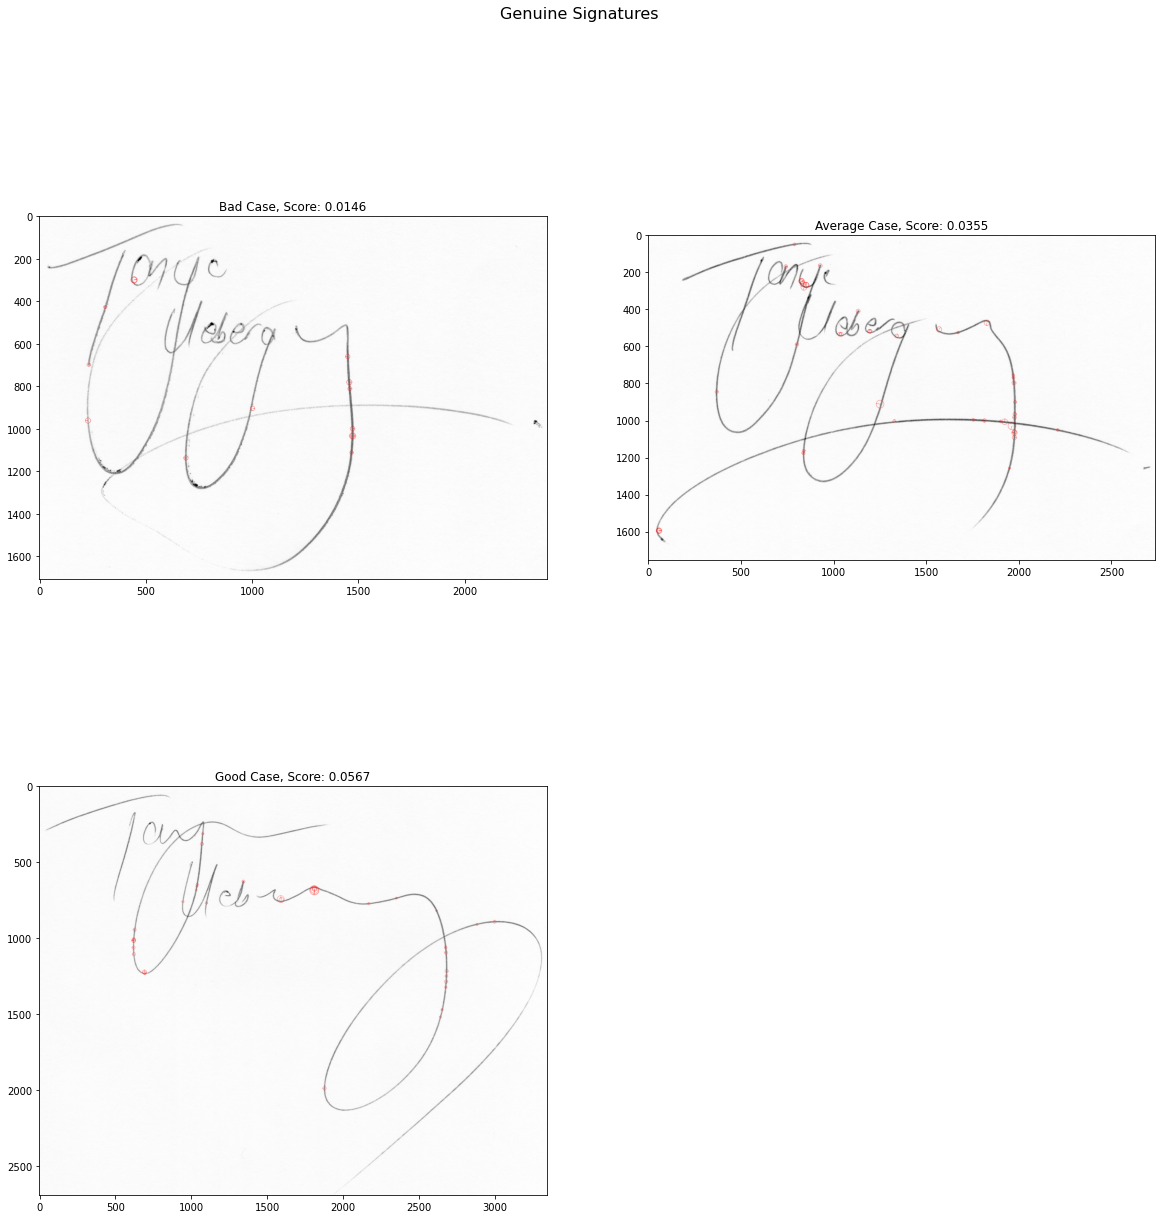

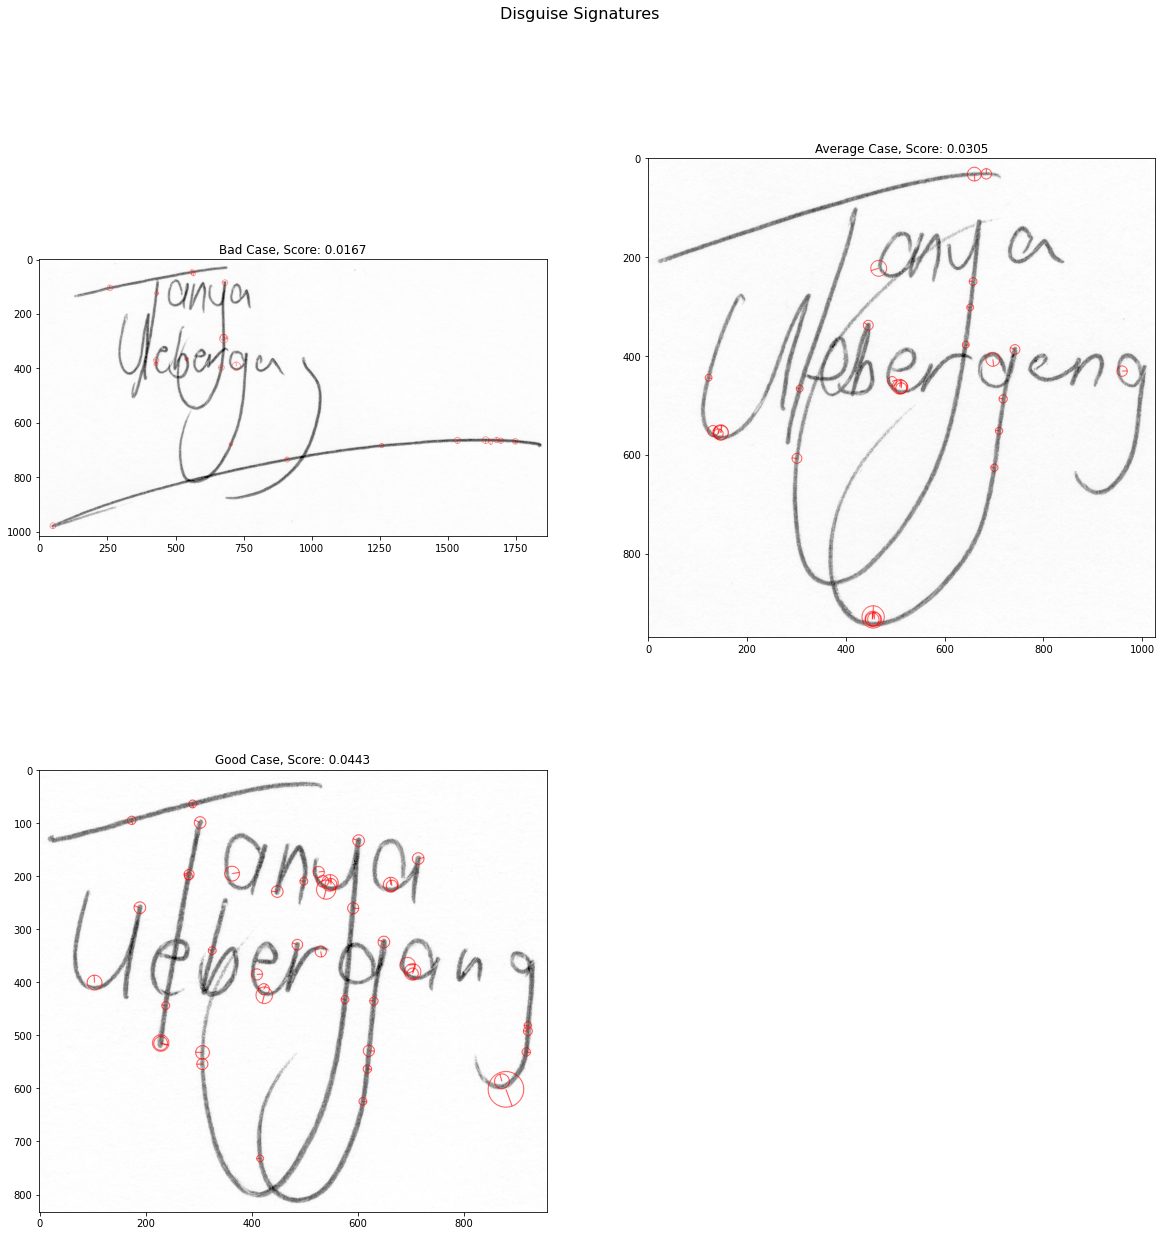

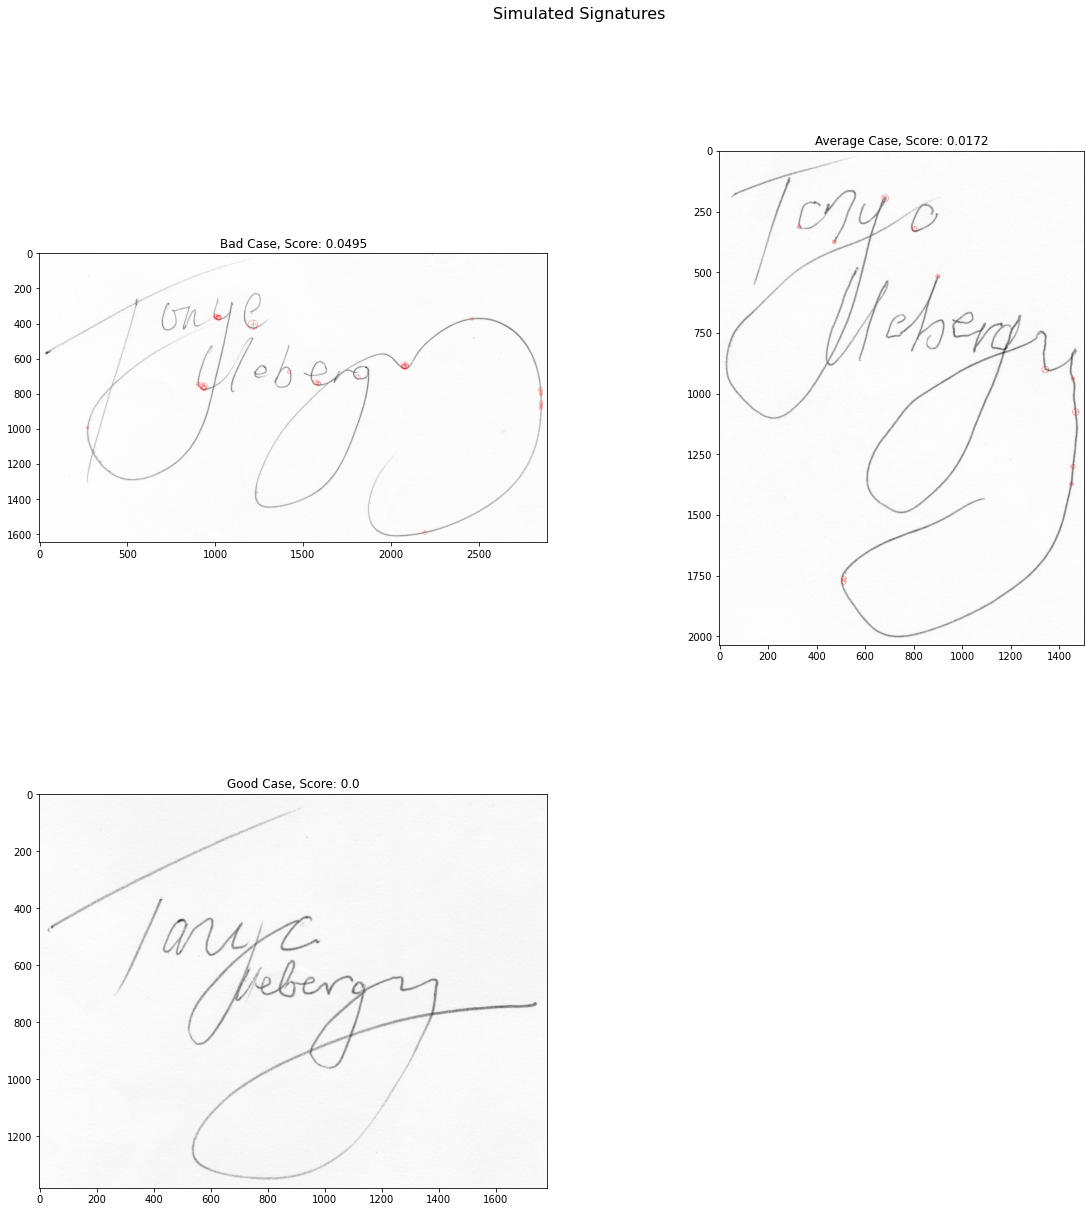

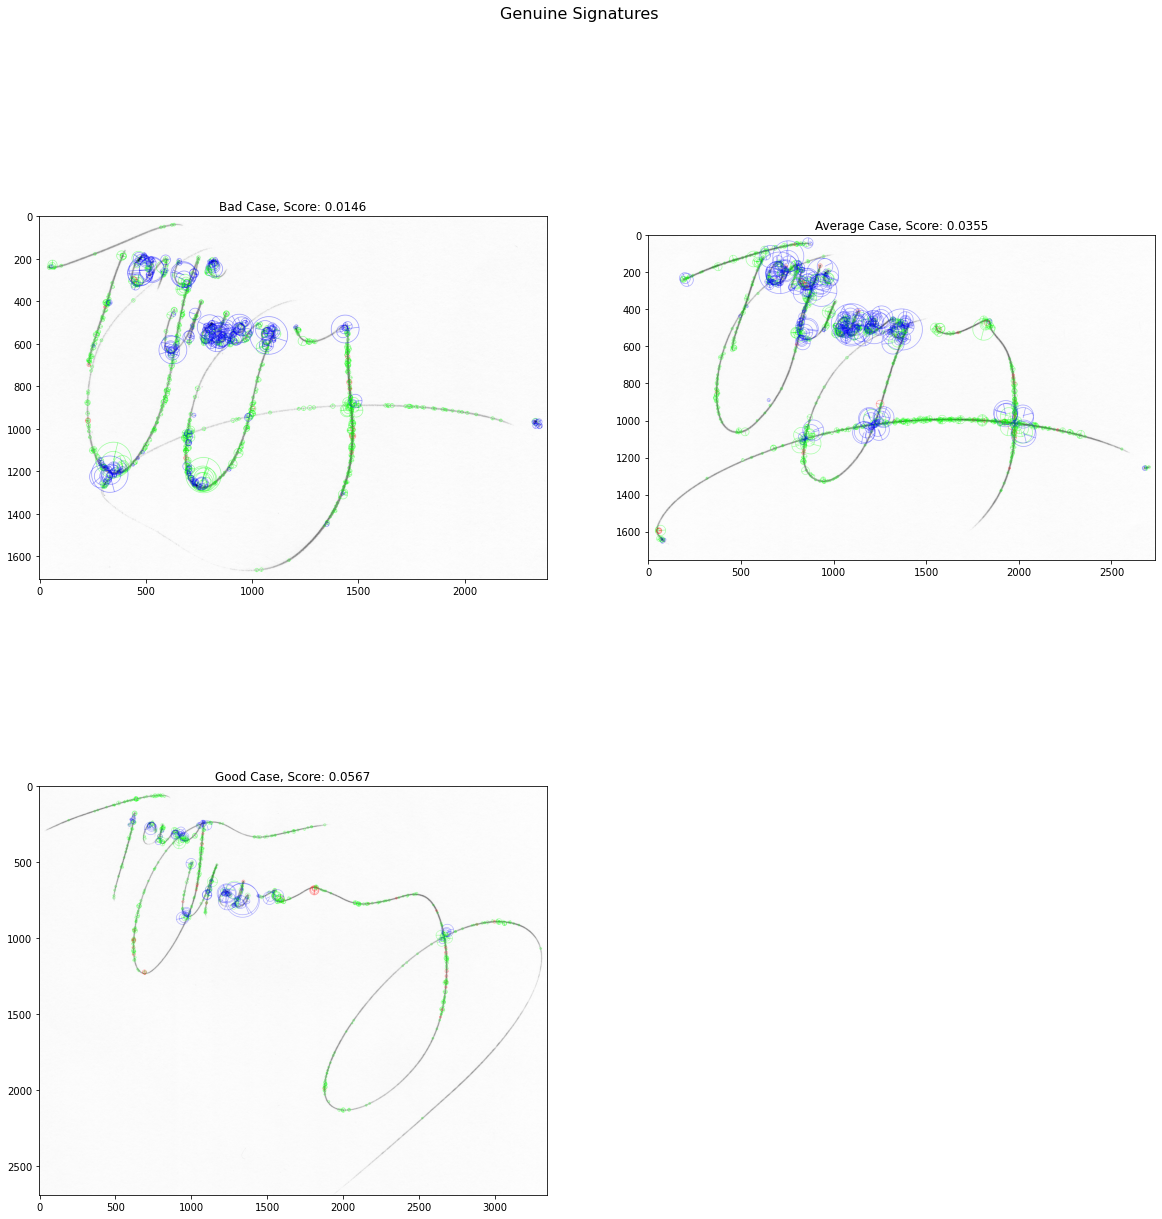

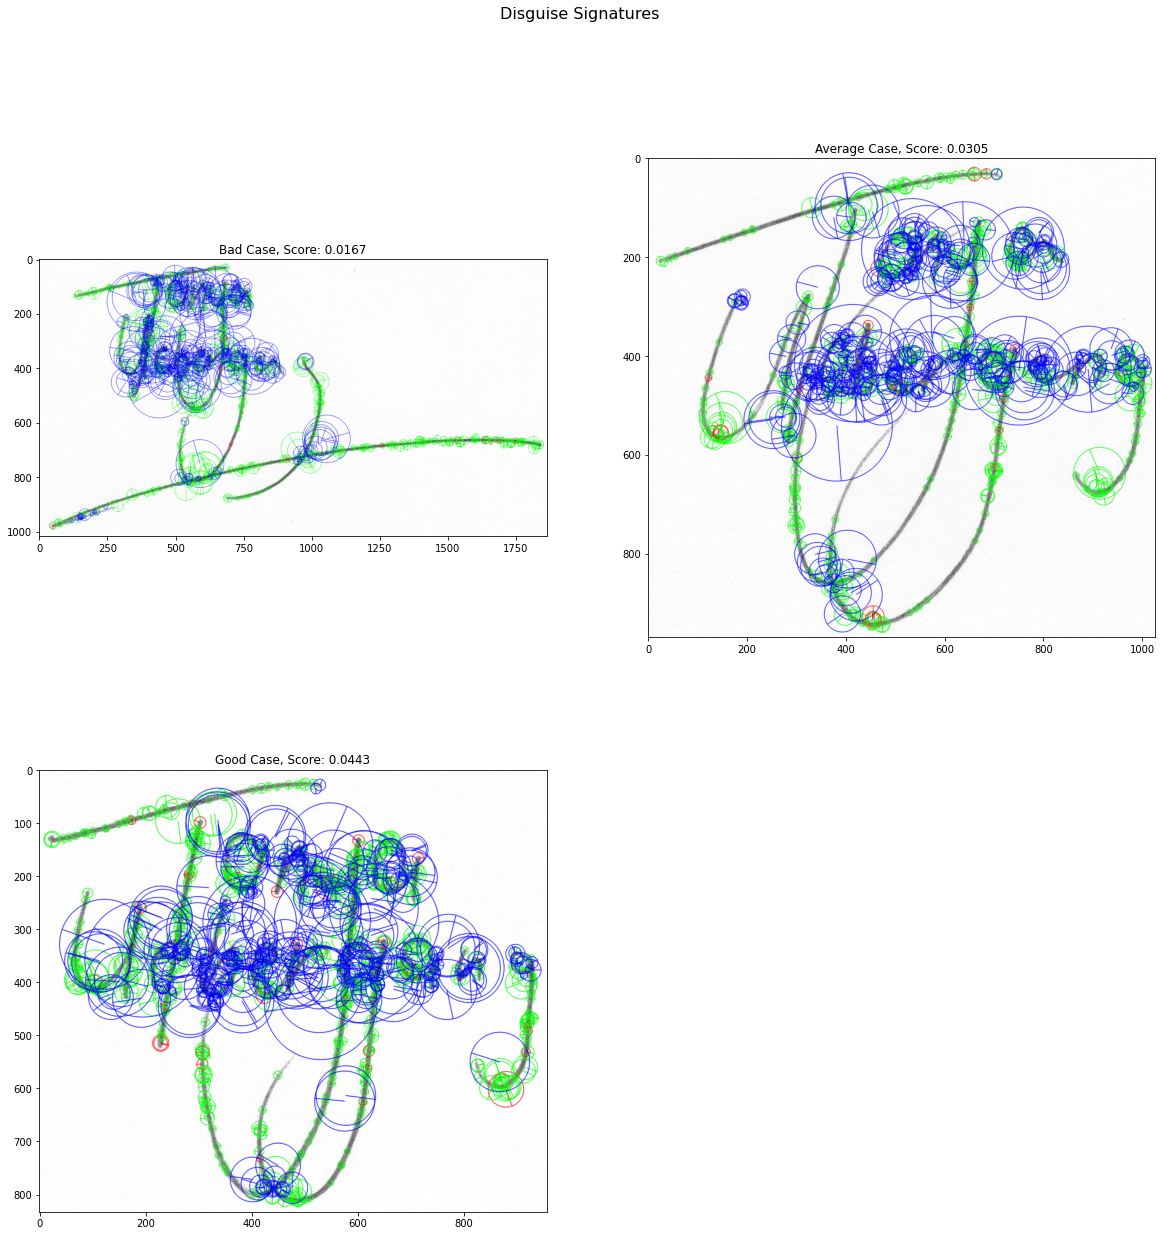

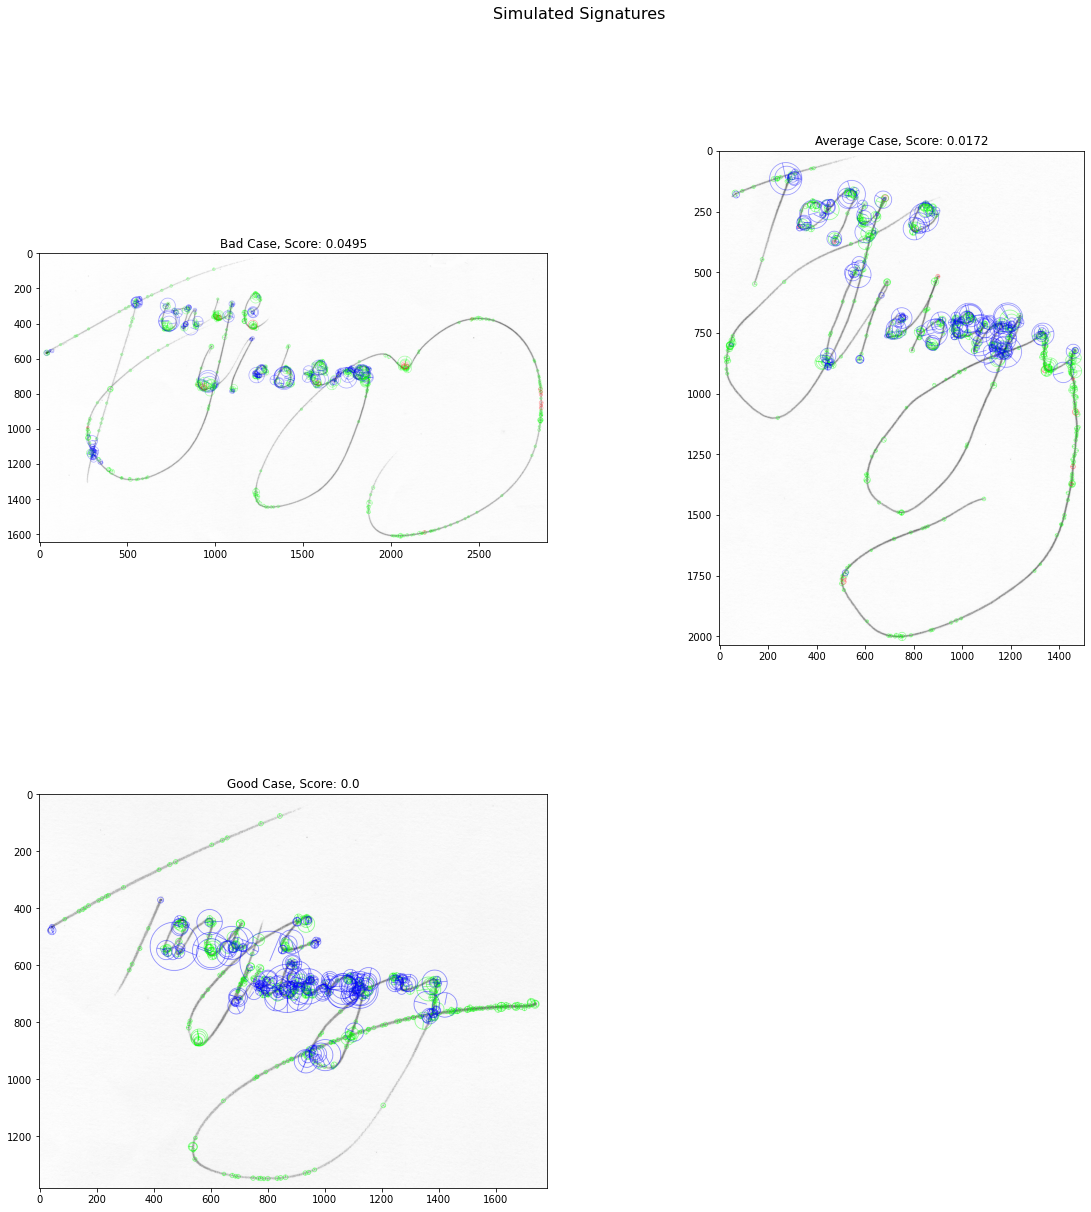

In [13]:
gm = np.argsort(genuine_match)
dm = np.argsort(disguise_match)
sm = np.argsort(simulated_match)
gm = gm[[0, int(gm.shape[0] / 2), -1]]
dm = dm[[0, int(dm.shape[0] / 2), -1]]
sm = sm[[-1, int(sm.shape[0] / 2), 0]]
matches = np.concatenate((np.array(genuine_match)[gm.astype(int)],np.array(disguise_match)[dm.astype(int)], np.array(simulated_match)[sm.astype(int)]))


img = []
img2 =[]
for i, type in enumerate(['Genuine', 'Disguise', 'Simulated']):
    path = '/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TrainingSet/' + type + '/'
    file_names = os.listdir(path)
    for j in [gm, dm, sm][i]:
        i1,j1=annotate(cv2.imread(path + file_names[j],
                             cv2.IMREAD_GRAYSCALE), DB, threshold)
        img.append(i1)
        img2.append(j1)
        

# Display
for i, type in enumerate(['Genuine', 'Disguise', 'Simulated']):
    fig = plt.figure(figsize = (20, 20))
    fig.suptitle(type + ' Signatures', fontsize = 16)
    for j, case in enumerate(['Bad Case', 'Average Case', 'Good Case']):
        plt.subplot(2, 2, j + 1)
        plt.imshow(img[3 * i + j])
        plt.title(case + ', Score: ' + str(round(matches[3 * i + j], 4)))
    plt.savefig('/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Plots/Demo' + str(i + 1) + '.jpg')
    plt.show()     

# Display
for i, type in enumerate(['Genuine', 'Disguise', 'Simulated']):
    fig = plt.figure(figsize = (20, 20))
    fig.suptitle(type + ' Signatures', fontsize = 16)
    for j, case in enumerate(['Bad Case', 'Average Case', 'Good Case']):
        plt.subplot(2, 2, j + 1)
        plt.imshow(img2[3 * i + j])
        plt.title(case + ', Score: ' + str(round(matches[3 * i + j], 4)))
    plt.savefig('/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Plots/Demo' + str(i + 1) + '.jpg')
    plt.show()          